In [3]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OrdinalEncoder, StandardScaler, RobustScaler, Normalizer, MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, balanced_accuracy_score, make_scorer
import numpy as np
import pickle
from sklearn.impute import KNNImputer
import imblearn
from sklearn import metrics

from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from utils.general_utils import save_model
from sklearn.model_selection import train_test_split, GridSearchCV,cross_val_score, RepeatedStratifiedKFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, balanced_accuracy_score
import imblearn
from imblearn.pipeline import Pipeline

from sklearn.manifold import TSNE # TSNE module
from sklearn.decomposition import PCA



from utils.general_utils import get_outlier_info, get_outlier_val_counts, clean_outliers
from utils.saver_utils import save_normalizer, load_normalizer
from utils.saver_utils import save_dataset, load_dataset 

In [4]:
from scipy import stats

In [5]:
datasetv2_save_path = "dataset/dataset_v2"
imputed_df = pd.read_csv(f'{datasetv2_save_path}/imputed_df.csv', index_col=0)
imputed_df.head()

,pcr,rfs,Age,ER,PgR,LNStatus,original_shape_Elongation,original_shape_Flatness,original_shape_LeastAxisLength,original_shape_MajorAxisLength,...,ChemoGrade_1.0,ChemoGrade_2.0,ChemoGrade_3.0,Proliferation_1.0,Proliferation_2.0,Proliferation_3.0,TumourStage_1.0,TumourStage_2.0,TumourStage_3.0,TumourStage_4.0
0,1.0,144.0,41.0,0.0,0.0,1.0,0.813912,0.724080,23.781937,32.844370,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
1,0.0,142.0,39.0,1.0,1.0,1.0,0.666118,0.476173,20.715461,43.504095,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
2,1.0,135.0,31.0,0.0,0.0,0.0,0.645083,0.594470,21.659822,36.435505,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
3,0.0,12.0,35.0,0.0,0.0,1.0,0.770842,0.501228,26.590504,53.050724,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
4,0.0,109.0,61.0,1.0,0.0,0.0,0.861035,0.750267,20.456571,27.265716,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0


In [19]:
train, test = train_test_split(imputed_df, test_size=0.20)

In [20]:
multi_category_variables = ['ChemoGrade_1.0', 'ChemoGrade_2.0', 'ChemoGrade_3.0', 'Proliferation_1.0', 'Proliferation_2.0',
       'Proliferation_3.0', 'TumourStage_1.0', 'TumourStage_2.0', 'TumourStage_3.0', 'TumourStage_4.0']

categorical_features_labels = ['ER', 'PgR', 'LNStatus'] + multi_category_variables

continous_features_labels = imputed_df.drop(columns=categorical_features_labels+['pcr', 'rfs']).columns

In [21]:
train_continous_feature_array = train[continous_features_labels].to_numpy()

test_continous_feature_array = test[continous_features_labels].to_numpy()

In [22]:
# scalerTrainX = StandardScaler()
# scalerTrainY = StandardScaler()


# scalerTrainX = RobustScaler()
# scalerTrainY = RobustScaler()

scalerTrainX = MinMaxScaler()
scalerTrainY = MinMaxScaler()


train_cont_X = scalerTrainX.fit_transform(train_continous_feature_array)
train_cat_X = train[categorical_features_labels].to_numpy()
trainX = np.hstack((train_cat_X, train_cont_X))
                   
trainY = scalerTrainY.fit_transform(train['rfs'].to_numpy().reshape(-1, 1))

                   
test_cont_X = scalerTrainX.transform(test_continous_feature_array)
test_cat_X = test[categorical_features_labels].to_numpy()
testX = np.hstack((test_cat_X, test_cont_X))
                   
testY = scalerTrainY.transform(test['rfs'].to_numpy().reshape(-1, 1))


In [23]:
trainX.shape, trainY.shape, testX.shape, testY.shape

((320, 60), (320, 1), (80, 60), (80, 1))

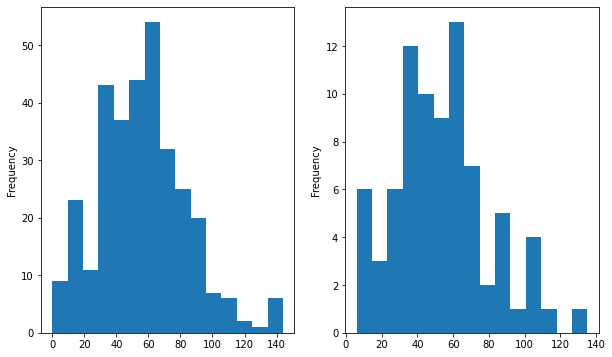

In [24]:
fig, axes = plt.subplots(1,2, figsize=(10, 6))

train['rfs'].plot(kind='hist', bins=15, ax=axes[0])
test['rfs'].plot(kind='hist', bins=15, ax=axes[1])

plt.show()

In [25]:
best_params = {'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'absolute_error',
 'max_depth': 10,
 'max_features': 20,
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 4,
 'min_samples_split': 5,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 0,
 'verbose': 0,
 'warm_start': False}

In [26]:
regressor = RandomForestRegressor(**best_params)
regressor.fit(trainX, trainY.ravel())

RandomForestRegressor(criterion='absolute_error', max_depth=10, max_features=20,
                      min_samples_leaf=4, min_samples_split=5, random_state=0)

Mean Absolute Error (MAE):

MAE measures the average absolute difference between the predicted and actual values. It gives you an idea of the average magnitude of errors in your predictions.
MAE is scale-dependent, meaning its value is in the same unit as the target variable. Therefore, the interpretation of whether an MAE of 0.15 is good or bad depends on the scale of your target variable.

In [41]:
predicted = regressor.predict(testX)
test_mse_error = mean_squared_error(testY, predicted,)
test_mae_error = mean_absolute_error(testY, predicted)
test_r2_error = r2_score(testY, predicted)

print(f'MSE error: {test_mse_error}')
print(f'MAE error: {test_mae_error}')
print(f'R2 error: {test_r2_error}')

MSE error: 0.03062291176576628
MAE error: 0.1431936487267361
R2 error: 0.07483434585817372


In [35]:
testY.shape

(80, 1)

In [37]:
pred_inverse_norm_vals = scalerTrainY.inverse_transform(predicted.reshape(1,-1)).flatten()
gt_inverse_norm_vals = scalerTrainY.inverse_transform(testY.reshape(1,-1)).flatten()

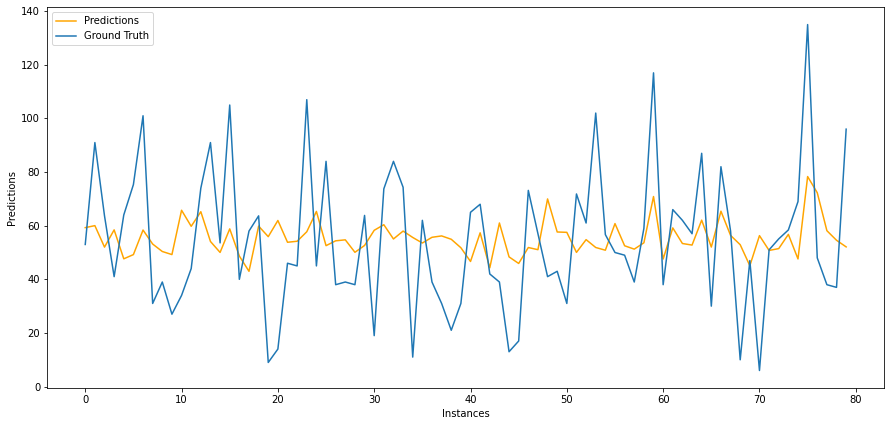

In [36]:
plt.figure(figsize=(15,7))
plt.plot(list(range(len(predicted))), scalerTrainY.inverse_transform(predicted.reshape(1,-1)).flatten(),
         color='orange', label='Predictions')
plt.plot(list(range(len(predicted))),scalerTrainY.inverse_transform(testY.reshape(1,-1)).flatten(),
         label='Ground Truth')
plt.xlabel("Instances")
plt.ylabel("Predictions")
plt.legend()
plt.show()

In [38]:
# Define a dictionary containing Students data
data = {'GT': gt_inverse_norm_vals,
        'Predictions': pred_inverse_norm_vals}
 
# Convert the dictionary into DataFrame
df = pd.DataFrame(data)
 

In [39]:
df

,GT,Predictions
0,53.000000,59.279167
1,91.000000,60.023333
2,63.666667,52.017083
3,41.000000,58.444583
4,64.000000,47.650833
...,...,...
75,135.000000,78.325417
76,48.000000,72.291667
77,38.000000,58.135000
78,37.000000,54.567083


# Training a MLP model


In [52]:
# regrMLP  = MLPRegressor(random_state=1, solver='sgd', early_stopping=True, max_iter=200, learning_rate='adaptive', verbose=True, hidden_layer_sizes=10, batch_size=8)

In [45]:
regrMLP  = MLPRegressor(random_state=1, batch_size=8)
regrMLP.fit(trainX, trainY.ravel())

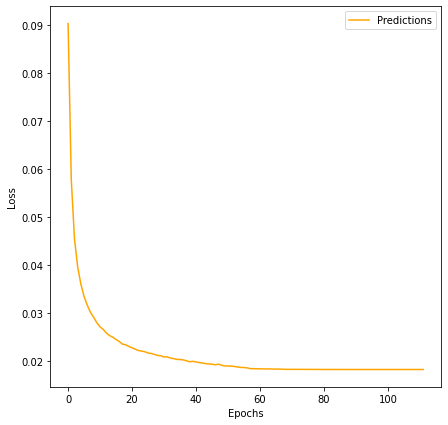

In [54]:
plt.figure(figsize=(7,7))
plt.plot(list(range(len(regrMLP.loss_curve_))), regrMLP.loss_curve_, color='orange', label='Predictions')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend();
plt.show()

In [55]:
predicted = regrMLP.predict(testX)
test_mse_error = mean_squared_error(testY, predicted,)
test_mae_error = mean_absolute_error(testY, predicted)
test_r2_error = r2_score(testY, predicted)

print(f'MSE error: {test_mse_error}')
print(f'MAE error: {test_mae_error}')
print(f'R2 error: {test_r2_error}')

MSE error: 0.03736115265104821
MAE error: 0.15707722623453013
R2 error: -0.1287383608811674


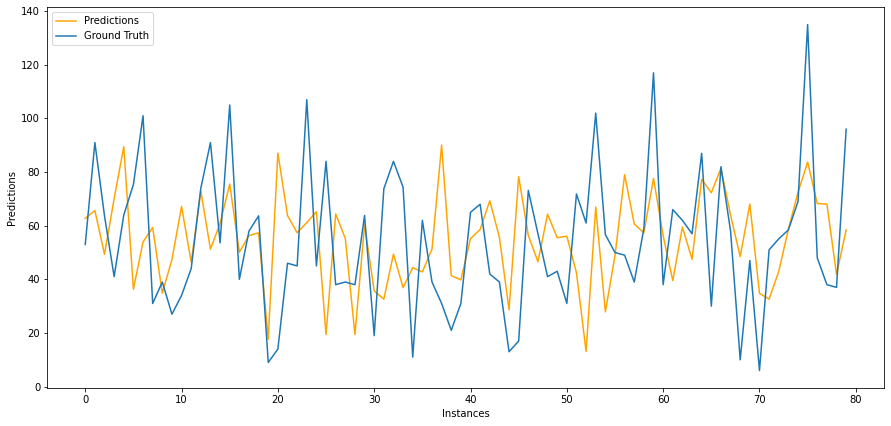

In [56]:
plt.figure(figsize=(15,7))
plt.plot(list(range(len(predicted))), scalerTrainY.inverse_transform(predicted.reshape(1,-1)).flatten(),
         color='orange', label='Predictions')
plt.plot(list(range(len(predicted))),scalerTrainY.inverse_transform(testY.reshape(1,-1)).flatten(),
         label='Ground Truth')
plt.xlabel("Instances")
plt.ylabel("Predictions")
plt.legend()
plt.show()

# Gridsearch for MLP

In [57]:
hidden_layer_sizes = [9, 12, 18, 20]
activation = ['logistic', 'tanh', 'relu']
solver = ['sgd', 'adam']
batch_size = [8, 16]
learning_rate = ['adaptive', 'invscaling', 'constant']
max_iter = [100, 150, 200, 250]
early_stopping=[True]

parameters = dict(hidden_layer_sizes=hidden_layer_sizes, activation=activation, solver=solver,
                  batch_size=batch_size, learning_rate=learning_rate,
                  max_iter=max_iter, early_stopping=early_stopping)

In [58]:
regrMLP  = MLPRegressor()
regrMLP_GS = GridSearchCV(regrMLP, parameters)
regrMLP_GS.fit(trainX, trainY.ravel())

C:\Users\sudar\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (150) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\sudar\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (250) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\sudar\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\sudar\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\sudar\anaconda3\lib\site-packages\sklearn\neural_network\_multi

GridSearchCV(estimator=MLPRegressor(),
             param_grid={'activation': ['logistic', 'tanh', 'relu'],
                         'batch_size': [8, 16], 'early_stopping': [True],
                         'hidden_layer_sizes': [9, 12, 18, 20],
                         'learning_rate': ['adaptive', 'invscaling',
                                           'constant'],
                         'max_iter': [100, 150, 200, 250],
                         'solver': ['sgd', 'adam']})

In [59]:
regrMLP_GS.best_estimator_.get_params() 

{'activation': 'logistic',
 'alpha': 0.0001,
 'batch_size': 8,
 'beta_1': 0.9,
 'beta_2': 0.999,
 'early_stopping': True,
 'epsilon': 1e-08,
 'hidden_layer_sizes': 12,
 'learning_rate': 'invscaling',
 'learning_rate_init': 0.001,
 'max_fun': 15000,
 'max_iter': 200,
 'momentum': 0.9,
 'n_iter_no_change': 10,
 'nesterovs_momentum': True,
 'power_t': 0.5,
 'random_state': None,
 'shuffle': True,
 'solver': 'sgd',
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': False,
 'warm_start': False}

In [61]:
regrMLP  = MLPRegressor(**regrMLP_GS.best_estimator_.get_params() )
regrMLP.fit(trainX, trainY.ravel())

MLPRegressor(activation='logistic', batch_size=8, early_stopping=True,
             hidden_layer_sizes=12, learning_rate='invscaling', solver='sgd')

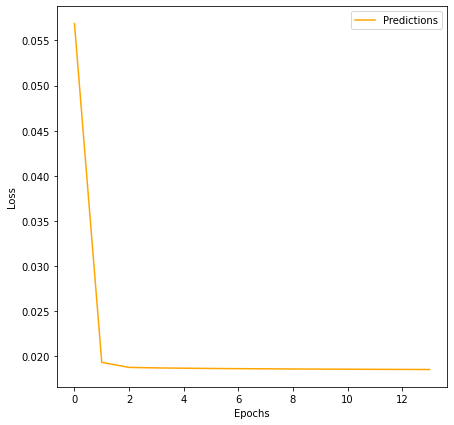

In [62]:
plt.figure(figsize=(7,7))
plt.plot(list(range(len(regrMLP.loss_curve_))), regrMLP.loss_curve_, color='orange', label='Predictions')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend();
plt.show()

In [63]:
predicted = regrMLP.predict(testX)
test_mse_error = mean_squared_error(testY, predicted,)
test_mae_error = mean_absolute_error(testY, predicted)
test_r2_error = r2_score(testY, predicted)

print(f'MSE error: {test_mse_error}')
print(f'MAE error: {test_mae_error}')
print(f'R2 error: {test_r2_error}')

MSE error: 0.034035909454626145
MAE error: 0.1439480346008955
R2 error: -0.02827760716415395


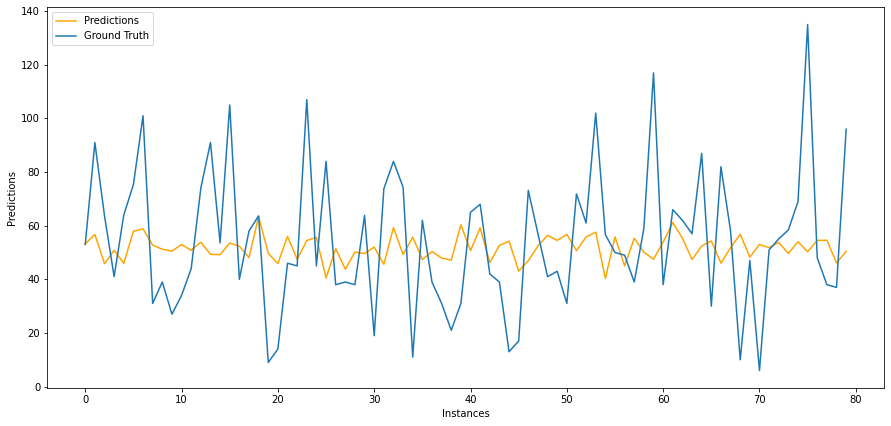

In [64]:
plt.figure(figsize=(15,7))
plt.plot(list(range(len(predicted))), scalerTrainY.inverse_transform(predicted.reshape(1,-1)).flatten(),
         color='orange', label='Predictions')
plt.plot(list(range(len(predicted))),scalerTrainY.inverse_transform(testY.reshape(1,-1)).flatten(),
         label='Ground Truth')
plt.xlabel("Instances")
plt.ylabel("Predictions")
plt.legend()
plt.show()

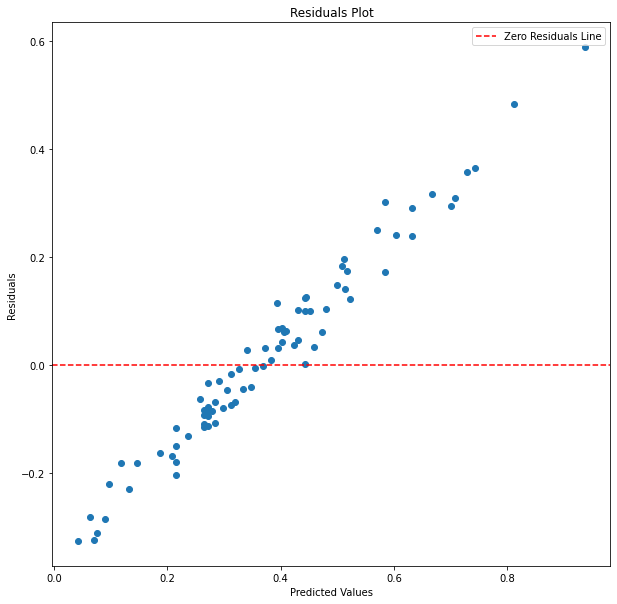

In [74]:
# Calculate residuals
residuals = testY.ravel() - predicted

# Plot residuals
plt.figure(figsize=(10,10))
plt.scatter(testY.ravel(), residuals)
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title("Residuals Plot")
plt.axhline(y=0, color='r', linestyle='--', label="Zero Residuals Line")
plt.legend()
plt.show()

In [78]:
description_df = imputed_df.describe()

In [81]:
imputed_df.columns

Index(['pcr', 'rfs', 'Age', 'ER', 'PgR', 'LNStatus',
       'original_shape_Elongation', 'original_shape_Flatness',
       'original_shape_LeastAxisLength', 'original_shape_MajorAxisLength',
       'original_shape_Maximum2DDiameterColumn',
       'original_shape_Maximum2DDiameterRow',
       'original_shape_Maximum2DDiameterSlice', 'original_shape_MeshVolume',
       'original_shape_MinorAxisLength', 'original_shape_Sphericity',
       'original_shape_SurfaceVolumeRatio', 'original_firstorder_10Percentile',
       'original_firstorder_90Percentile',
       'original_firstorder_InterquartileRange',
       'original_firstorder_Kurtosis', 'original_firstorder_Maximum',
       'original_firstorder_Mean', 'original_firstorder_Minimum',
       'original_firstorder_Skewness', 'original_glcm_Autocorrelation',
       'original_glcm_ClusterShade', 'original_glcm_Correlation',
       'original_glcm_Imc1', 'original_gldm_DependenceEntropy',
       'original_gldm_DependenceVariance',
       'origin

In [8]:
right_skewed= [6, 7, 15, 25, 28, 31, 34, 41]
left_skewed = [8, 9, 10, 11, 12 , 13, 14, 20, 21, 27, 32, 35, 36, 40, 42, 46, 49]
normal_dist = [16, 17, 18, 19, 22, 23, 24, 29, 30, 33, 37, 38, 39, 47, 48]
weird_AF = [26, 43, 44, 45, 50, 51, 57, 58]

In [10]:
right_skewed_columns = [imputed_df.columns[col_num] for col_num in left_skewed]

In [11]:
left_skewed_columns = [imputed_df.columns[col_num] for col_num in right_skewed]

In [22]:
weird_columns = [imputed_df.columns[col_num] for col_num in weird_AF]

In [56]:
weird_columns

['original_glcm_ClusterShade',
 'original_glszm_LargeAreaEmphasis',
 'original_glszm_LargeAreaHighGrayLevelEmphasis',
 'original_glszm_LargeAreaLowGrayLevelEmphasis',
 'original_ngtdm_Busyness',
 'original_ngtdm_Strength',
 'Proliferation_3.0',
 'TumourStage_1.0']

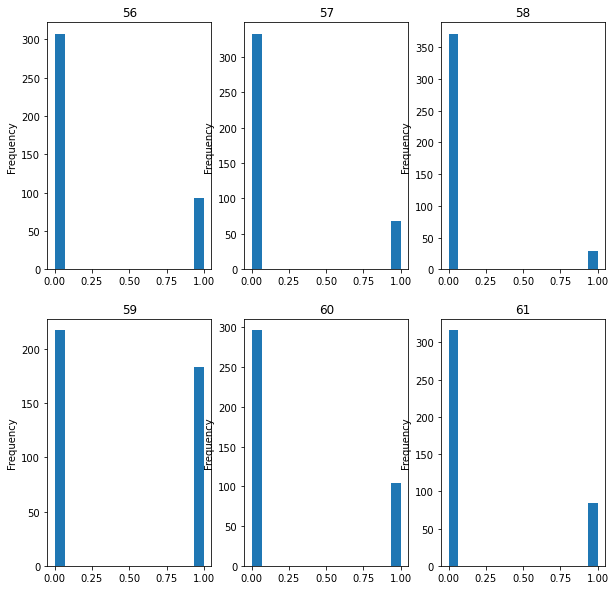

In [131]:
fig, axes = plt.subplots(2,3, figsize=(10, 10))

i=56

imputed_df[imputed_df.columns[i]].plot(kind='hist', bins=15, ax=axes[0,0], title=f'{i}')
imputed_df[imputed_df.columns[i+1]].plot(kind='hist', bins=15, ax=axes[0,1], title=f'{i+1}')
imputed_df[imputed_df.columns[i+2]].plot(kind='hist', bins=15, ax=axes[0,2], title=f'{i+2}')

imputed_df[imputed_df.columns[i+3]].plot(kind='hist', bins=15, ax=axes[1,0], title=f'{i+3}')
imputed_df[imputed_df.columns[i+4]].plot(kind='hist', bins=15, ax=axes[1,1], title=f'{i+4}')
imputed_df[imputed_df.columns[i+5]].plot(kind='hist', bins=15, ax=axes[1,2], title=f'{i+5}')


plt.show()

# Handling Right skewed dataset with log transform

In [164]:
# right_skewed_log_df = imputed_df[right_skewed_columns].copy()
right_skewed_log_df = imputed_df.copy()
right_skewed_log_df[right_skewed_columns] = right_skewed_log_df[right_skewed_columns].apply(lambda x: np.log1p(x))


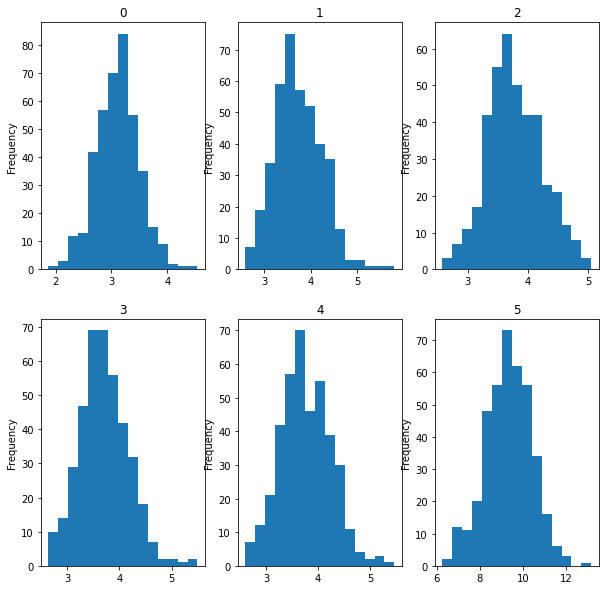

In [165]:
fig, axes = plt.subplots(2,3, figsize=(10, 10))

i=0

right_skewed_log_df[right_skewed_columns[i]].plot(kind='hist', bins=15, ax=axes[0,0], title=f'{i}')
right_skewed_log_df[right_skewed_columns[i+1]].plot(kind='hist', bins=15, ax=axes[0,1], title=f'{i+1}')
right_skewed_log_df[right_skewed_columns[i+2]].plot(kind='hist', bins=15, ax=axes[0,2], title=f'{i+2}')

right_skewed_log_df[right_skewed_columns[i+3]].plot(kind='hist', bins=15, ax=axes[1,0], title=f'{i+3}')
right_skewed_log_df[right_skewed_columns[i+4]].plot(kind='hist', bins=15, ax=axes[1,1], title=f'{i+4}')
right_skewed_log_df[right_skewed_columns[i+5]].plot(kind='hist', bins=15, ax=axes[1,2], title=f'{i+5}')


plt.show()

# Handling Left skewed features with log transform does not work
# Trying with Box Cox Transformation

In [6]:
from scipy.stats import boxcox


In [12]:
left_skewed_log_df = imputed_df[left_skewed_columns].copy()

# Applying the Box-Cox transformation using a lambda function

left_skewed_log_df[left_skewed_columns] = left_skewed_log_df[left_skewed_columns].apply(lambda x: boxcox(x + 1)[0])


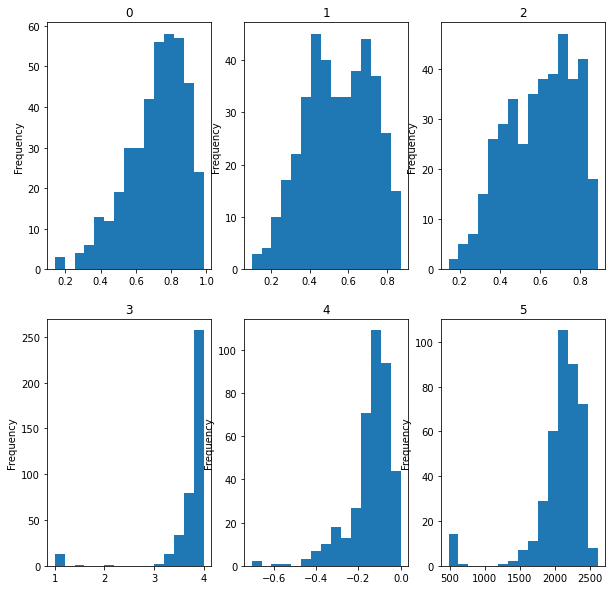

In [13]:
fig, axes = plt.subplots(2,3, figsize=(10, 10))

i=0

imputed_df[left_skewed_log_df.columns[i]].plot(kind='hist', bins=15, ax=axes[0,0], title=f'{i}')
imputed_df[left_skewed_log_df.columns[i+1]].plot(kind='hist', bins=15, ax=axes[0,1], title=f'{i+1}')
imputed_df[left_skewed_log_df.columns[i+2]].plot(kind='hist', bins=15, ax=axes[0,2], title=f'{i+2}')

imputed_df[left_skewed_log_df.columns[i+3]].plot(kind='hist', bins=15, ax=axes[1,0], title=f'{i+3}')
imputed_df[left_skewed_log_df.columns[i+4]].plot(kind='hist', bins=15, ax=axes[1,1], title=f'{i+4}')
imputed_df[left_skewed_log_df.columns[i+5]].plot(kind='hist', bins=15, ax=axes[1,2], title=f'{i+5}')


plt.show()

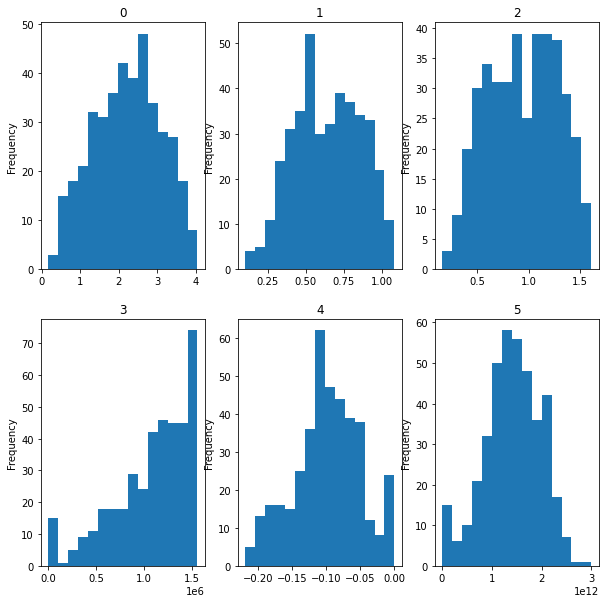

In [14]:
fig, axes = plt.subplots(2,3, figsize=(10, 10))

i=0

left_skewed_log_df[left_skewed_log_df.columns[i]].plot(kind='hist', bins=15, ax=axes[0,0], title=f'{i}')
left_skewed_log_df[left_skewed_log_df.columns[i+1]].plot(kind='hist', bins=15, ax=axes[0,1], title=f'{i+1}')
left_skewed_log_df[left_skewed_log_df.columns[i+2]].plot(kind='hist', bins=15, ax=axes[0,2], title=f'{i+2}')

left_skewed_log_df[left_skewed_log_df.columns[i+3]].plot(kind='hist', bins=15, ax=axes[1,0], title=f'{i+3}')
left_skewed_log_df[left_skewed_log_df.columns[i+4]].plot(kind='hist', bins=15, ax=axes[1,1], title=f'{i+4}')
left_skewed_log_df[left_skewed_log_df.columns[i+5]].plot(kind='hist', bins=15, ax=axes[1,2], title=f'{i+5}')


plt.show()

In [80]:
# description_df.to_csv('dataset/dataset_v2/imputed_df_decription.csv')

# Testing with Right skew handled data

In [166]:
train, test = train_test_split(right_skewed_log_df, test_size=0.20)

multi_category_variables = ['ChemoGrade_1.0', 'ChemoGrade_2.0', 'ChemoGrade_3.0', 'Proliferation_1.0', 'Proliferation_2.0',
       'Proliferation_3.0', 'TumourStage_1.0', 'TumourStage_2.0', 'TumourStage_3.0', 'TumourStage_4.0']

categorical_features_labels = ['ER', 'PgR', 'LNStatus'] + multi_category_variables

continous_features_labels = right_skewed_log_df.drop(columns=categorical_features_labels+['pcr', 'rfs']).columns

train_continous_feature_array = train[continous_features_labels].to_numpy()

test_continous_feature_array = test[continous_features_labels].to_numpy()


scalerTrainX = MinMaxScaler()
scalerTrainY = MinMaxScaler()


train_cont_X = scalerTrainX.fit_transform(train_continous_feature_array)
train_cat_X = train[categorical_features_labels].to_numpy()
trainX = np.hstack((train_cat_X, train_cont_X))
                   
trainY = scalerTrainY.fit_transform(train['rfs'].to_numpy().reshape(-1, 1))

                   
test_cont_X = scalerTrainX.transform(test_continous_feature_array)
test_cat_X = test[categorical_features_labels].to_numpy()
testX = np.hstack((test_cat_X, test_cont_X))
                   
testY = scalerTrainY.transform(test['rfs'].to_numpy().reshape(-1, 1))


In [167]:
best_params = {'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'absolute_error',
 'max_depth': 10,
 'max_features': 20,
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 4,
 'min_samples_split': 5,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 0,
 'verbose': 0,
 'warm_start': False}

regressor = RandomForestRegressor(**best_params)
regressor.fit(trainX, trainY.ravel())


RandomForestRegressor(criterion='absolute_error', max_depth=10, max_features=20,
                      min_samples_leaf=4, min_samples_split=5, random_state=0)

In [172]:
regressor = RandomForestRegressor()
regressor.fit(trainX, trainY.ravel())

RandomForestRegressor()

In [173]:

predicted = regressor.predict(testX)
test_mse_error = mean_squared_error(testY, predicted,)
test_mae_error = mean_absolute_error(testY, predicted)
test_r2_error = r2_score(testY, predicted)

print(f'MSE error: {test_mse_error}')
print(f'MAE error: {test_mae_error}')
print(f'R2 error: {test_r2_error}')



MSE error: 0.03264764117377299
MAE error: 0.1393086031170324
R2 error: -0.05473514416653957


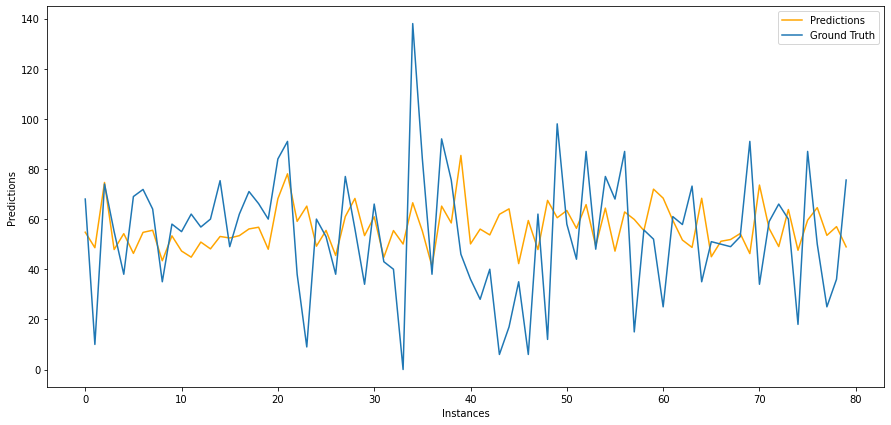

In [174]:

plt.figure(figsize=(15,7))
plt.plot(list(range(len(predicted))), scalerTrainY.inverse_transform(predicted.reshape(1,-1)).flatten(),
         color='orange', label='Predictions')
plt.plot(list(range(len(predicted))),scalerTrainY.inverse_transform(testY.reshape(1,-1)).flatten(),
         label='Ground Truth')
plt.xlabel("Instances")
plt.ylabel("Predictions")
plt.legend()
plt.show()

# Testing with Handling Right and left skewed data not dropping the weird columns

In [34]:
skew_handled_df = imputed_df.copy()
skew_handled_df.drop(columns=weird_columns, inplace=True)
# Applying the Box-Cox transformation using a lambda function

skew_handled_df[left_skewed_columns] = skew_handled_df[left_skewed_columns].apply(lambda x: boxcox(x + 1)[0])

In [48]:
left_skewed_columns[0]

'original_shape_Elongation'

In [47]:
from scipy.stats import skew

In [55]:
skew(imputed_df[left_skewed_columns[6]]), skew(skew_handled_df[left_skewed_columns[6]])

(-1.267701826274862, -0.12082884681070084)

In [49]:
data_skewness = skew(imputed_df['original_shape_Elongation'])

In [53]:

for col_name in right_skewed_columns:
    data_skewness = skew(imputed_df[col_name])

    if data_skewness > 0:
        print("The data is right-skewed.")
    elif data_skewness < 0:
        print("The data is left-skewed.")
    else:
        print("The data is approximately symmetric.")

The data is right-skewed.
The data is right-skewed.
The data is right-skewed.
The data is right-skewed.
The data is right-skewed.
The data is right-skewed.
The data is right-skewed.
The data is right-skewed.
The data is right-skewed.
The data is right-skewed.
The data is right-skewed.
The data is right-skewed.
The data is right-skewed.
The data is right-skewed.
The data is right-skewed.
The data is right-skewed.
The data is right-skewed.


In [35]:
# right_skewed_log_df = imputed_df[right_skewed_columns].copy()
skew_handled_df[right_skewed_columns] = skew_handled_df[right_skewed_columns].apply(lambda x: np.log1p(x))


In [43]:
train, test = train_test_split(skew_handled_df, test_size=0.20)

# multi_category_variables = ['ChemoGrade_1.0', 'ChemoGrade_2.0', 'ChemoGrade_3.0', 'Proliferation_1.0', 'Proliferation_2.0',
#        'Proliferation_3.0', 'TumourStage_1.0', 'TumourStage_2.0', 'TumourStage_3.0', 'TumourStage_4.0']


# Removed Proliferation_3.0', 'TumourStage_1.0' because it was part of the weird columns
multi_category_variables = ['ChemoGrade_1.0', 'ChemoGrade_2.0', 'ChemoGrade_3.0', 'Proliferation_1.0', 'Proliferation_2.0',
       'TumourStage_2.0', 'TumourStage_3.0', 'TumourStage_4.0']
categorical_features_labels = ['ER', 'PgR', 'LNStatus'] + multi_category_variables

continous_features_labels = skew_handled_df.drop(columns=categorical_features_labels+['pcr', 'rfs']).columns

train_continous_feature_array = train[continous_features_labels].to_numpy()

test_continous_feature_array = test[continous_features_labels].to_numpy()


# scalerTrainX = RobustScaler()
# scalerTrainY = RobustScaler()

# scalerTrainX = StandardScaler()
# scalerTrainY = StandardScaler()

scalerTrainX = MinMaxScaler()
scalerTrainY = MinMaxScaler()


train_cont_X = scalerTrainX.fit_transform(train_continous_feature_array)
train_cat_X = train[categorical_features_labels].to_numpy()
trainX = np.hstack((train_cat_X, train_cont_X))
                   
trainY = scalerTrainY.fit_transform(train['rfs'].to_numpy().reshape(-1, 1))

                   
test_cont_X = scalerTrainX.transform(test_continous_feature_array)
test_cat_X = test[categorical_features_labels].to_numpy()
testX = np.hstack((test_cat_X, test_cont_X))
                   
testY = scalerTrainY.transform(test['rfs'].to_numpy().reshape(-1, 1))


In [44]:
regressor = RandomForestRegressor()
regressor.fit(trainX, trainY.ravel())

RandomForestRegressor()

In [45]:

predicted = regressor.predict(testX)
test_mse_error = mean_squared_error(testY, predicted,)
test_mae_error = mean_absolute_error(testY, predicted)
test_r2_error = r2_score(testY, predicted)

print(f'MSE error: {test_mse_error}')
print(f'MAE error: {test_mae_error}')
print(f'R2 error: {test_r2_error}')



MSE error: 0.03461160807492514
MAE error: 0.1495188802077604
R2 error: -0.019984429136390647


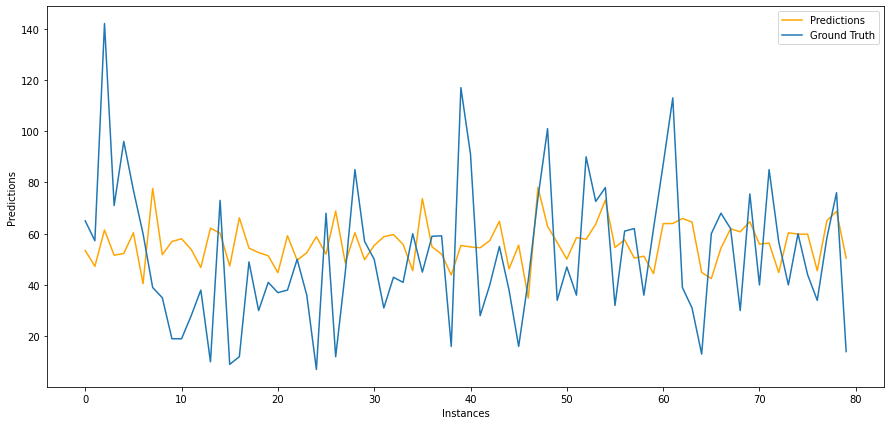

In [46]:

plt.figure(figsize=(15,7))
plt.plot(list(range(len(predicted))), scalerTrainY.inverse_transform(predicted.reshape(1,-1)).flatten(),
         color='orange', label='Predictions')
plt.plot(list(range(len(predicted))),scalerTrainY.inverse_transform(testY.reshape(1,-1)).flatten(),
         label='Ground Truth')
plt.xlabel("Instances")
plt.ylabel("Predictions")
plt.legend()
plt.show()

###### TODO
1. Perform Box Cox transformation and train
2. Check if you still have outliers
3. remove weird columns
4. Use OG dataframe, erpform above processing then do correlation and then remove features and train